In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print(tf.__version__)

2.8.0


In [2]:
#importing dataset
files_dir = "../dataset/"
filename = files_dir + "AB_NYC_2019.csv"
df = pd.read_csv(filename)

<AxesSubplot:>

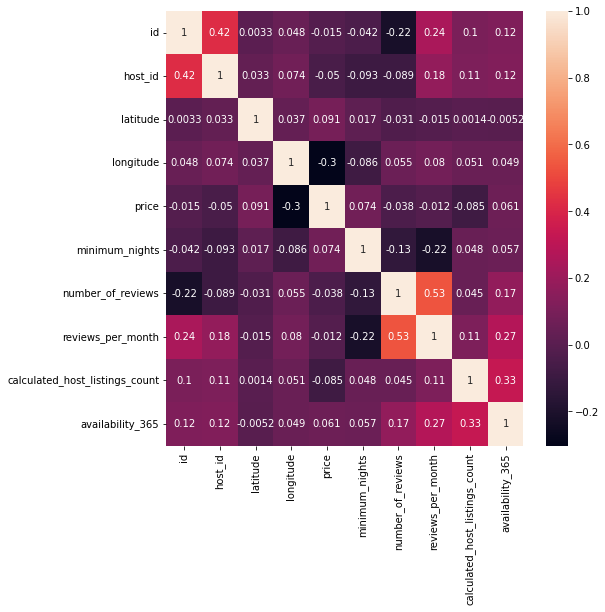

In [3]:
corr = df.corr(method='kendall')
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)

In [4]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df['reviews_per_month']=df['reviews_per_month'].fillna(0)

In [5]:
columns=['id','host_id','name','host_name','last_review','calculated_host_listings_count']
df=df.drop(columns,axis=1)
df.isnull().sum()

neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
number_of_reviews      0
reviews_per_month      0
availability_365       0
dtype: int64

Text(0.5, 1.0, 'Neighbourhood')

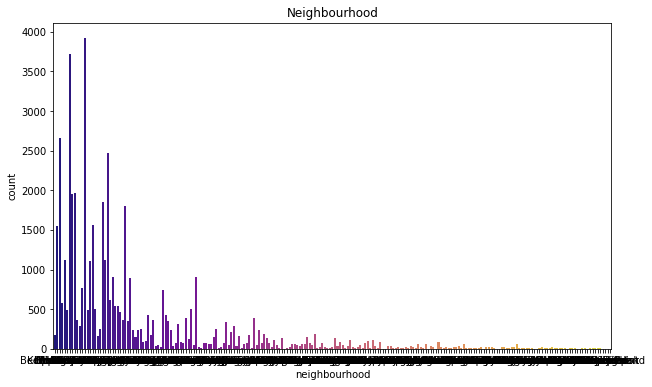

In [6]:
sns.countplot(df['neighbourhood'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.title('Neighbourhood')

In [7]:
df['neighbourhood_group']=pd.factorize(df.neighbourhood_group)[0]
df['neighbourhood']=pd.factorize(df.neighbourhood)[0]
df['room_type']=pd.factorize(df.room_type)[0]

df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,0,0,40.64749,-73.97237,0,149,1,9,0.21,365
1,1,1,40.75362,-73.98377,1,225,1,45,0.38,355
2,1,2,40.80902,-73.94190,0,150,3,0,0.00,365
3,0,3,40.68514,-73.95976,1,89,1,270,4.64,194
4,1,4,40.79851,-73.94399,1,80,10,9,0.10,0


In [8]:
availabillity=df['availability_365']
availabillity=(availabillity-availabillity.mean())/availabillity.std()

In [9]:
Y=df['price']
X=df.copy()
X=X.drop(X['price'])

X.shape,Y.shape

((48221, 10), (48895,))

In [10]:
Y=Y.truncate(after=48220,axis=0)
X.shape,Y.shape

((48221, 10), (48221,))

In [11]:
max_long=df['longitude'].max()
min_long=df['longitude'].min()

diff=max_long-min_long
diff/=100

long_boundaries=[]
for i in np.arange(min_long, max_long, diff):
    long_boundaries.append(min_long+i*diff)

    
max_lat=df['latitude'].max()
min_lat=df['latitude'].min()

d=max_lat-min_lat
d/=100

lat_boundaries=[]
for i in np.arange(min_lat, max_lat, d):
    lat_boundaries.append(min_long+i*d)

In [12]:
long_marked=tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'), boundaries=long_boundaries
)

lat_marked=tf.feature_column.bucketized_column(
   tf.feature_column.numeric_column('latitude'),boundaries=lat_boundaries
)


crossed_feature=tf.feature_column.crossed_column([long_marked,lat_marked],hash_bucket_size=100)
feature_layer=tf.keras.layers.DenseFeatures(tf.feature_column.indicator_column(crossed_feature))

In [13]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=0)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linreg=LinearRegression()
linreg.fit(x_train,y_train)
y_pred=linreg.predict(x_test)
r2_score=r2_score(y_test,y_pred)
r2_score

-0.0005691749531513413

In [18]:
X

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
1,1,1,40.75362,-73.98377,1,225,1,45,0.38,355
2,1,2,40.80902,-73.94190,0,150,3,0,0.00,365
3,0,3,40.68514,-73.95976,1,89,1,270,4.64,194
4,1,4,40.79851,-73.94399,1,80,10,9,0.10,0
5,1,5,40.74767,-73.97500,1,200,3,74,0.59,129
...,...,...,...,...,...,...,...,...,...,...
48890,0,6,40.67853,-73.94995,0,70,2,0,0.00,9
48891,0,21,40.70184,-73.93317,0,40,4,0,0.00,36
48892,1,2,40.81475,-73.94867,1,115,10,0,0.00,27
48893,1,7,40.75751,-73.99112,2,55,1,0,0.00,2


In [17]:
from tensorflow.keras.layers import Dense, Dropout,DenseFeatures
tf.keras.backend.set_floatx('float32')
model = tf.keras.Sequential([
    DenseFeatures(feature_layer),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.3),
    Dense(32,activation='relu'),
    Dense(1)
])

opt=tf.keras.optimizers.Adam(learning_rate=0.05)
rmse=tf.keras.metrics.RootMeanSquaredError()
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mae',rmse])

TypeError: 'DenseFeatures' object is not iterable